# Echo Meeting 13th of February 2024

In [35]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
path = pathlib.Path.cwd()

## Overview
## Notebook Overview
This notebook has the following sections: 
1. [Landing on Prompts](#1-landing-on-prompts)
2. [Generating Data](#2-generating-data)
3. [Length Checking](#3-length-checking)
4. [Distance Plots](#4)

### (1) Landing on Prompts
* "dailymail_cnn_21": "summarize this in a few sentences: "
* "mrpc_21": "paraphrase this: "
* "stories_21": "write a story based on this: "
* "stories_22": "continue the story: "
* "dailydialog_21": "continue the conversation between A and B by writing a single response to the latest speaker. write only a concise response and nothing else: "

As we talked about, these prompts should resemble what a regular user would write (i.e., no "prompt engineering") - maybe with the exception of dailydialog.

### (2) Generating Data
Data has been generated with `vLLM` for all of the above prompts for the temperatures 1, 1.5, 2 for models: 
1. llama-chat 7b (meta-llama/Llama-2-7b-chat-hf)
2. beluga 7b (stabilityai/StableBeluga-7B)
3. mistral 7b (mistralai/Mistral-7B-Instruct-v0.2)
4. llama-chat 13b (meta-llama/Llama-2-13b-chat-hf)

Higher temperatures (already at 2) seem to break generation more easily (more about this later!). We could consider whether we want greedy decoding (temperature = 0) also.

### (3) Length Checking

In [1]:
## insert code here

#### (4) Distance Plot

In [67]:
def jitterplot(data:pd.DataFrame, jitter:float=0.3, height_aspect:tuple=(10, 2), save_path:pathlib.Path=None):
    data['model'] = data['model'].astype(str)

    model_order = ["human", "mistral7b", "beluga7b", "llama2_chat7b", "llama2_chat13b"]

    # create plot
    plot = sns.catplot(
                    data=data, 
                    x="model",
                    y="distance", 
                    hue="dataset", 
                    kind="strip", 
                    dodge=True, 
                    palette="husl", 
                    jitter=jitter, 
                    height=height_aspect[0], 
                    aspect=height_aspect[1], 
                    order=model_order
                    )

    # set labels and title
    plt.subplots_adjust(top=0.9)
    plot.set_axis_labels("Model", "Distance")

    if save_path: 
        save_path.mkdir(parents=True, exist_ok=True)
        save_file = save_path / f"{dataset}.png"
        g.savefig(save_file, dpi=600)

    return plot

In [58]:
data_path = path.parents[0] / "results" / "analysis" / "distances_PC_cols.csv"
df = pd.read_csv(data_path)

In [59]:
# append "-22" to the string in "dataset" column when prompt number is 22
df["dataset"] = df.apply(lambda x: x["dataset"] + "-22" if x["prompt_number"] == 22 else x["dataset"], axis=1)

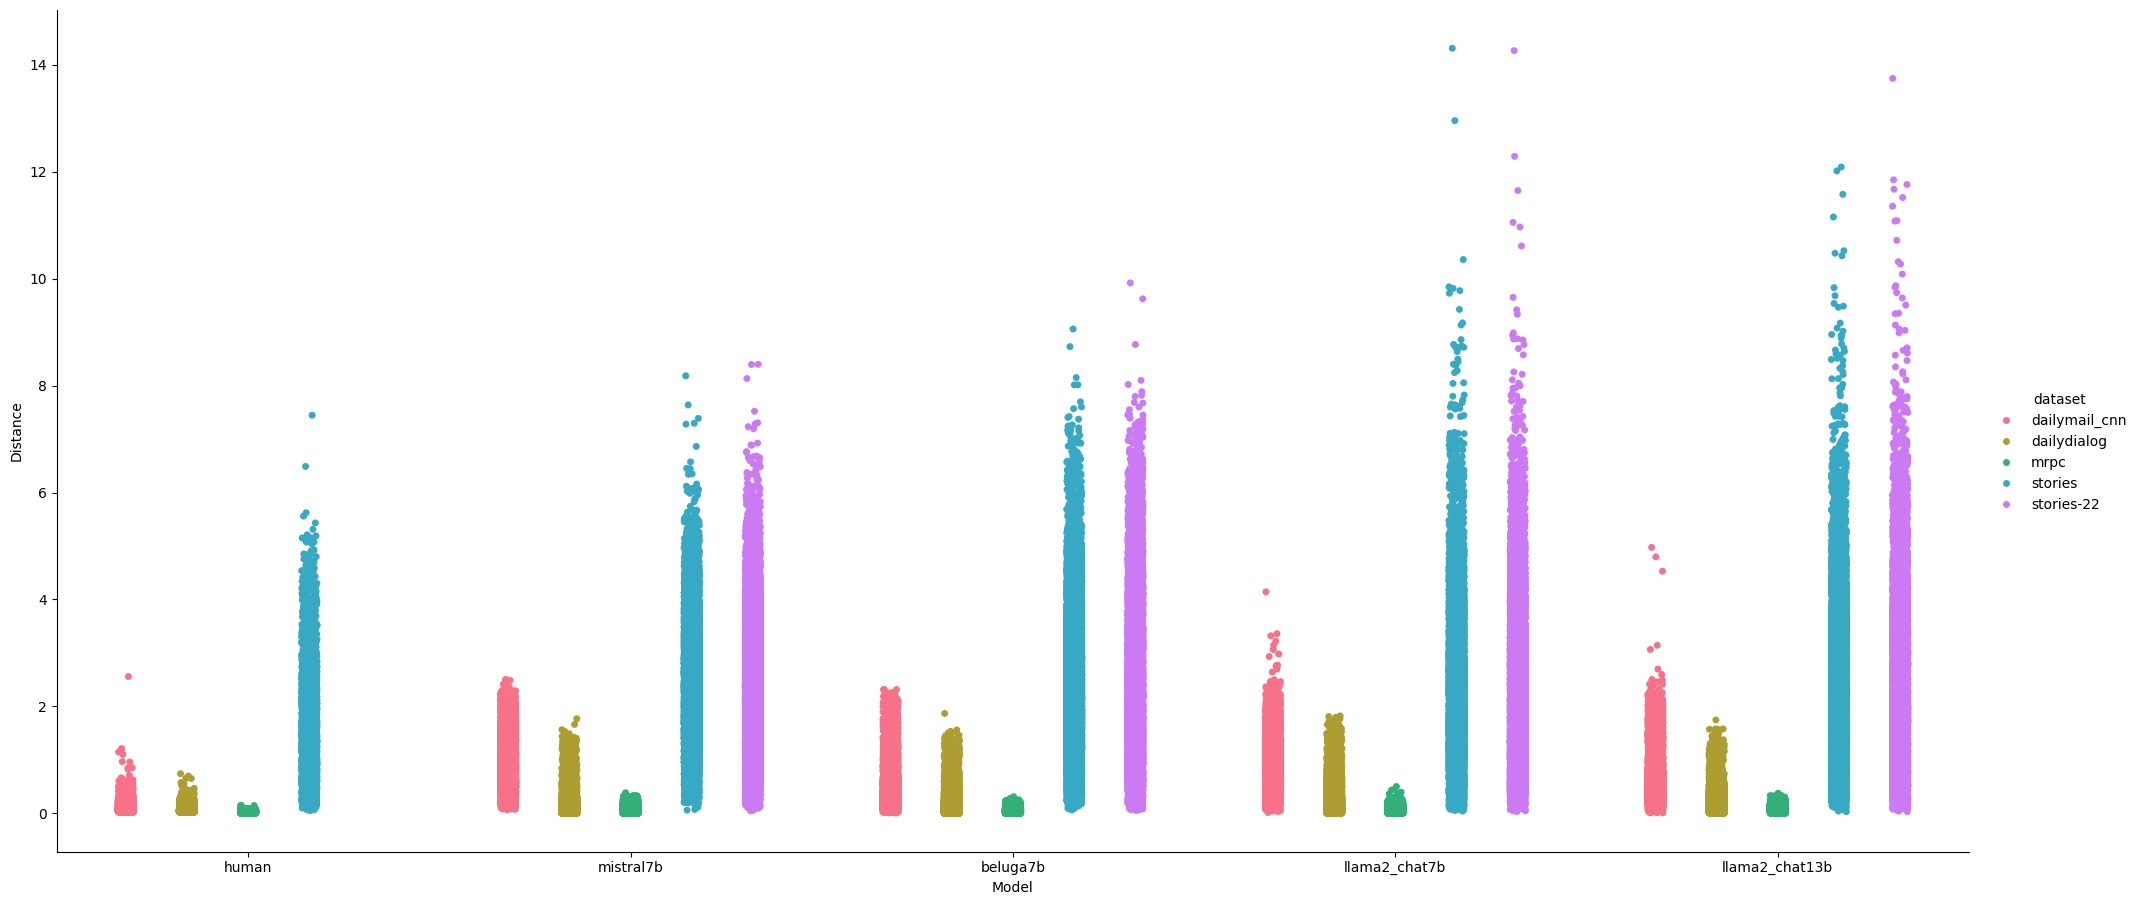

In [68]:
plot = jitterplot(df, jitter=0.1)

#### (5) Future Work
* Setting up a classifier pipeline (XGBOOST)? I have been looking at little at Ida's code already :))
* Experimental Design (NB. exam period aka May will be busy!)
* Clean up in repository (not urgent...)